# CMAP-Elites DEMO

## Imports

In [1]:
import json

GECCO-compatible `matplotlib` options:

In [2]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import `PCGSEPy` modules:

In [3]:
from pcgsepy.common.vecs import orientation_from_str, Vec 
from pcgsepy.config import COMMON_ATOMS, HL_ATOMS, N_ITERATIONS, REQ_TILES 
from pcgsepy.lsystem.rules import RuleMaker
from pcgsepy.lsystem.actions import AtomAction, Rotations
from pcgsepy.lsystem.parser import HLParser, LLParser
from pcgsepy.lsystem.solver import LSolver
from pcgsepy.lsystem.constraints import ConstraintHandler, ConstraintLevel, ConstraintTime
from pcgsepy.lsystem.constraints_funcs import components_constraint, intersection_constraint, symmetry_constraint, axis_constraint
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.structure import block_definitions
from pcgsepy.evo.genops import expander

## Setup

In [4]:
with open(COMMON_ATOMS, "r") as f:
    common_alphabet = json.load(f)

for k in common_alphabet:
    action, args = common_alphabet[k]["action"], common_alphabet[k]["args"]
    action = AtomAction(action)
    if action == AtomAction.MOVE:
        args = orientation_from_str[args]
    elif action == AtomAction.ROTATE:
        args = Rotations(args)
    common_alphabet[k] = {"action": action, "args": args}

In [5]:
with open(HL_ATOMS, "r") as f:
    hl_atoms = json.load(f)

tiles_dimensions = {}
tiles_block_offset = {}
for tile in hl_atoms.keys():
    dx, dy, dz = hl_atoms[tile]["dimensions"]
    tiles_dimensions[tile] = Vec.v3i(dx, dy, dz)
    tiles_block_offset[tile] = hl_atoms[tile]["offset"]

hl_alphabet = {}
for k in common_alphabet.keys():
    hl_alphabet[k] = common_alphabet[k]

for hk in hl_atoms.keys():
    hl_alphabet[hk] = {"action": AtomAction.PLACE, "args": []}

In [6]:
ll_alphabet = {}

for k in common_alphabet.keys():
    ll_alphabet[k] = common_alphabet[k]

# for k in block_definitions.keys():
#     if k != "":  # TODO: This is a probable bug, reported to the SE API devs
#         ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

In [7]:
used_ll_blocks = [
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCorner',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorSlope',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCornerInv',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorBlock',
    'MyObjectBuilder_Gyro_LargeBlockGyro',
    'MyObjectBuilder_Reactor_LargeBlockSmallGenerator',
    'MyObjectBuilder_CargoContainer_LargeBlockSmallContainer',
    'MyObjectBuilder_Cockpit_OpenCockpitLarge',
    'MyObjectBuilder_Thrust_LargeBlockSmallThrust',
    'MyObjectBuilder_InteriorLight_SmallLight',
    'MyObjectBuilder_CubeBlock_Window1x1Slope',
    'MyObjectBuilder_CubeBlock_Window1x1Flat',
    'MyObjectBuilder_InteriorLight_LargeBlockLight_1corner'
]

for k in used_ll_blocks:
    ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

## L-System components

In [8]:
hl_rules = RuleMaker(ruleset='hlrules').get_rules()
ll_rules = RuleMaker(ruleset='llrules').get_rules()

hl_parser = HLParser(rules=hl_rules)
ll_parser = LLParser(rules=ll_rules)

hl_solver = LSolver(parser=hl_parser,
                    atoms_alphabet=hl_alphabet,
                    extra_args={
                        'tiles_dimensions': tiles_dimensions,
                        'tiles_block_offset': tiles_block_offset,
                        'll_rules': ll_rules
                    })
ll_solver = LSolver(parser=ll_parser,
                    atoms_alphabet=dict(hl_alphabet, **ll_alphabet),
                    extra_args={})

In [9]:
rcc1 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc1.extra_args["req_tiles"] = ['cockpit']

rcc2 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc2.extra_args["req_tiles"] = ['corridorcargo', 'corridorgyros', 'corridorreactors']

rcc3 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc3.extra_args["req_tiles"] = ['thrusters']

nic = ConstraintHandler(
    name="no_intersections",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.DURING,
    f=intersection_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    },
    needs_ll=True
)
nic.extra_args["tiles_dimensions"] = tiles_dimensions

sc = ConstraintHandler(
    name="symmetry",
    level=ConstraintLevel.SOFT_CONSTRAINT,
    when=ConstraintTime.END,
    f=symmetry_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    }
)

In [10]:
lsystem = LSystem(
    hl_solver=hl_solver, ll_solver=ll_solver, names=['HeadModule', 'BodyModule', 'TailModule']
)

In [11]:
lsystem.add_hl_constraints(cs=[
    [nic, rcc1],
    [nic, rcc2],
    [nic, rcc3]
])

lsystem.add_ll_constraints(cs=[
    [sc],
    [sc],
    [sc]
])

In [12]:
expander.initialize(rules=lsystem.hl_solver.parser.rules)

## MAP-Elites

In [13]:
from pcgsepy.evo.fitness import box_filling_fitness, bounding_box_fitness, func_blocks_fitness, axis_fitness

feasible_fitnesses = [bounding_box_fitness,
                      box_filling_fitness,
                      func_blocks_fitness,
                      axis_fitness]

In [17]:
from pcgsepy.mapelites.map import MAPElites

In [18]:
mapelites = MAPElites(lsystem=lsystem,
                      feasible_fitnesses=feasible_fitnesses,
                      behavior_limits=(10, 20),
                      n_bins=(8, 8))

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

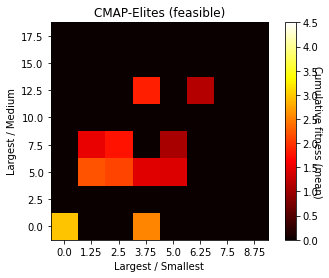

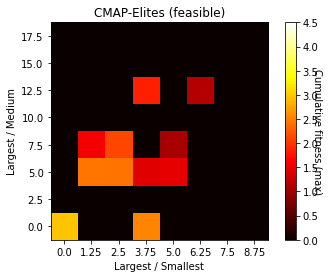

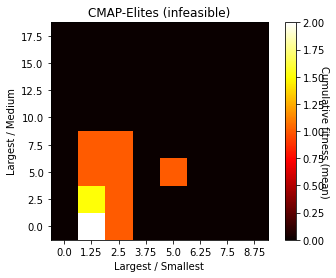

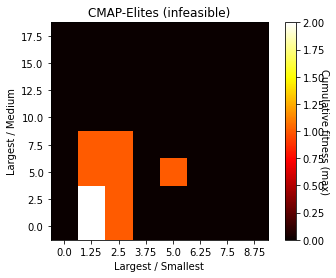

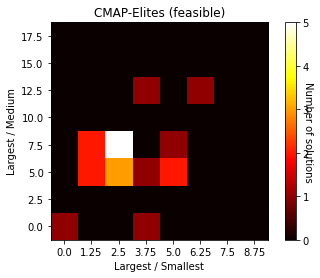

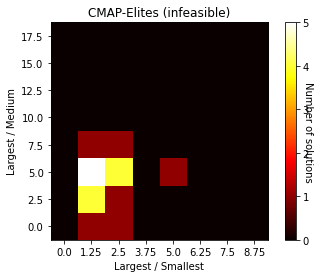

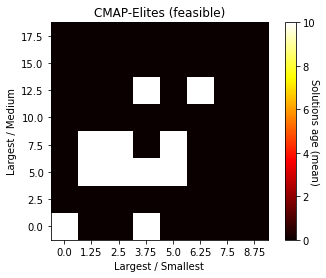

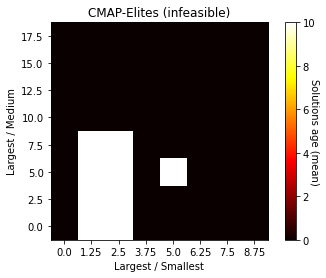

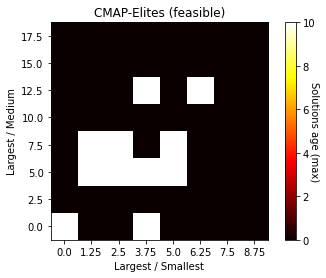

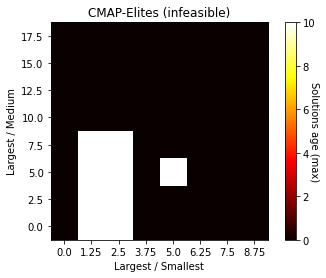

In [19]:
mapelites.generate_initial_populations(pops_size=20,
                                       n_retries=100)

mapelites.show_fitness(show_mean=True,
                       population='feasible')
mapelites.show_fitness(show_mean=False,
                       population='feasible')
mapelites.show_fitness(show_mean=True,
                       population='infeasible')
mapelites.show_fitness(show_mean=False,
                       population='infeasible')
mapelites.show_coverage(population='feasible')
mapelites.show_coverage(population='infeasible')
mapelites.show_age(show_mean=True,
                   population='feasible')
mapelites.show_age(show_mean=True,
                   population='infeasible')
mapelites.show_age(show_mean=False,
                   population='feasible')
mapelites.show_age(show_mean=False,
                   population='infeasible')

  0%|          | 0/5 [00:00<?, ?it/s]

['cockpitcorridorsimple(1)[RotYccwXcorridorsimple(2)]corridorsimple(1)corridorreactors(1)[RotYcwXcorridorsimple(1)]corridorsimple(1)[RotYccwZcorridorsimple(2)]corridorgyros(2)corridorcargo(1)thrusters', 'cockpitcorridorsimple(1)corridorreactors(1)corridorgyros(1)corridorcargo(2)[RotYcwXcorridorsimple(1)thrusters(1)]thrusters']
['cockpitcorridorsimple(1)[RotYcwXcorridorsimple(1)]corridorcargo(2)[RotYccwZcorridorsimple(1)]corridorcargo(1)thrusters', 'cockpitcorridorsimple(1)corridorsimple(2)[RotYccwXcorridorsimple(1)]corridorgyros(1)corridorsimple(1)[RotYcwXcorridorsimple(1)]corridorsimple(1)[RotYccwXcorridorsimple(2)]corridorsimple(1)[RotYccwZcorridorsimple(2)]corridorcargo(2)thrusters', 'cockpitcorridorsimple(1)[RotYccwZcorridorsimple(1)]corridorgyros(1)corridorgyros(1)corridorsimple(1)[RotYccwZcorridorsimple(1)][RotYccwXcorridorsimple(2)]corridorsimple(1)[RotYccwXcorridorsimple(2)][RotYccwZcorridorsimple(2)]thrusters', 'cockpitcorridorsimple(1)corridorcargo(2)[RotYcwZcorridorsimple(1)

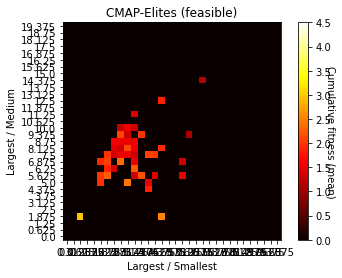

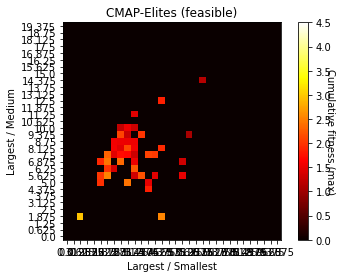

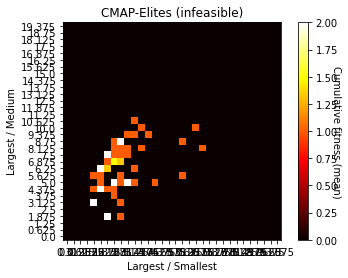

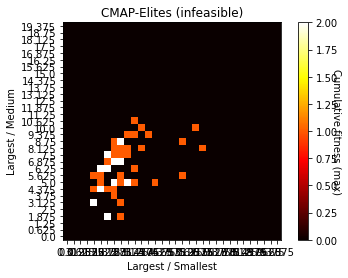

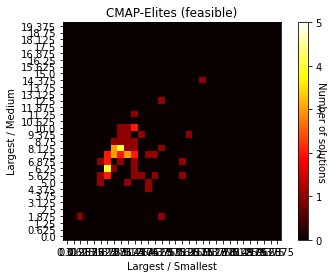

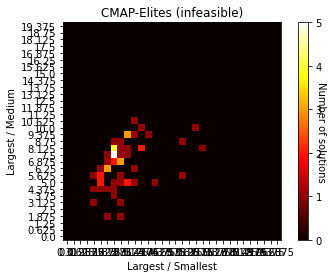

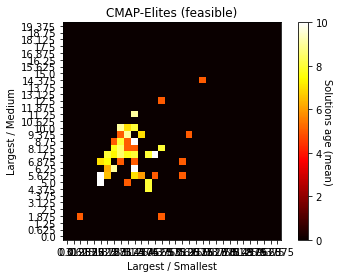

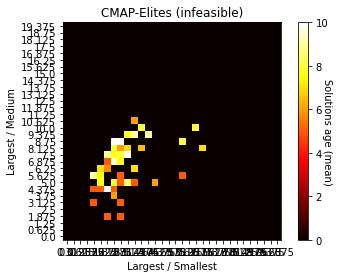

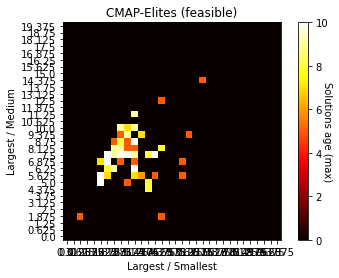

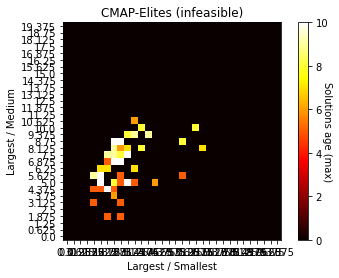

In [20]:
from tqdm.notebook import trange

for i in trange(5):
    mapelites.rand_step(gen=i)

# mapelites.interactive_mode(n_steps=5)

mapelites.show_fitness(show_mean=True,
                       population='feasible')
mapelites.show_fitness(show_mean=False,
                       population='feasible')
mapelites.show_fitness(show_mean=True,
                       population='infeasible')
mapelites.show_fitness(show_mean=False,
                       population='infeasible')
mapelites.show_coverage(population='feasible')
mapelites.show_coverage(population='infeasible')
mapelites.show_age(show_mean=True,
                   population='feasible')
mapelites.show_age(show_mean=True,
                   population='infeasible')
mapelites.show_age(show_mean=False,
                   population='feasible')
mapelites.show_age(show_mean=False,
                   population='infeasible')

## DASH

In [21]:
!pip install dash dash-html-components dash-core-components

In [22]:
!pip install pandas

In [23]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import numpy as np

In [24]:
app = dash.Dash(__name__)

disp_map = np.zeros(shape=mapelites.bins.shape)
for i in range(mapelites.bins.shape[0]):
    for j in range(mapelites.bins.shape[1]):
        disp_map[i, j] = mapelites.bins[i,
                                   j].get_metric(metric='fitness',
                                                 use_mean=True,
                                                 population='feasible')
fig = go.Figure(data=go.Heatmap(x=np.arange(disp_map.shape[0]).tolist(),
                                y=np.arange(disp_map.shape[1]).tolist(),
                                z=disp_map.tolist(),
                                type='heatmap',
                                colorscale='Viridis'))

app.layout = html.Div([
    html.P("Fitness landscape:"),
    dcc.Graph(id="graph", figure=fig),
])


app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
